# VAR


In [221]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy.linalg import inv
#from pandas_datareader.data import DataReader 
from numpy import linalg as LA
%matplotlib inline

In [230]:
###Importing the data
df = pd.read_excel('Narrative_MP_Brazil_Dataset_with_Controls.xlsx', index_col=0, parse_dates=True)
df["fci"]=df["logfci"]
df["ipca_log"] = df["ipca_log"]
df["pimsa_log"] = df["pimsa_log"]
df["logbrlem"]=df["logbrlem"]
df

Selic  Selic_d   ibcbr  ibcbrsa  ibcbrsa_log       pim     pimsa  \
Data                                                                           
2003-01-31  25.50      0.0   96.15   100.38     4.608963  73.98043  79.79383   
2003-02-28  26.50      1.0   98.67   102.07     4.625659  71.78186  79.49492   
2003-03-31  26.50      0.0  103.41   102.05     4.625463  77.41394  79.42228   
2003-04-30  26.50      0.0  102.19   100.87     4.613833  76.52576  79.24657   
2003-05-31  26.50      0.0  100.30    99.80     4.603168  79.68128  78.04771   
...           ...      ...     ...      ...          ...       ...       ...   
2022-02-28  10.75      1.5  136.31   141.71     4.953783  75.87402  85.56588   
2022-03-31  11.75      1.0  148.42   143.22     4.964382  84.49285  86.07131   
2022-04-30  11.75      0.0  142.17   142.48     4.959202  80.88910  86.20807   
2022-05-31  12.75      1.0  142.75   142.11     4.956601  88.75731  86.48873   
2022-06-30  13.25      0.5  142.37   143.09     4.963474  87.45102  86.13488   

            pimsa_log     pmcsa  pmcsa_log  ...  logbrlem    logfci    ff4_tc  \
Data                                        ...                                 
2003-01-31   4.379446  45.79915   3.824266  ...  3.536599  4.612237  0.311834   
2003-02-28   4.375693  47.05212   3.851256  ...  3.516771  4.608856 -0.100611   
2003-03-31   4.374779  45.76213   3.823457  ...  3.571905  4.607309  0.109469   
2003-04-30   4.372564  45.65779   3.821174  ...  3.669013  4.613821  0.094514   
2003-05-31   4.357320  45.19273   3.810936  ...  3.649944  4.614964  0.063899   
...               ...       ...        ...  ...       ...       ...       ...   
2022-02-28   4.449287  99.31007   4.598247  ...  3.620483  4.593053 -0.051733   
2022-03-31   4.455176  98.57361   4.590804  ...  3.674674  4.593363 -0.006746   
2022-04-30   4.456764  97.51749   4.580032  ...  3.652052  4.595396  0.000000   
2022-05-31   4.460014  97.83140   4.583246  ...  3.687894  4.594328  0.069891   
2022-06-30   4.455914  95.53430   4.559485  ...  3.609993  4.596440 -0.038480   

            Choque  Choque_pos  Choque_neg  D_greve  D_covid  D_GFC       fci  
Data                                                                           
2003-01-31       0           0           0        0        0      0  4.612237  
2003-02-28       0           0           0        0        0      0  4.608856  
2003-03-31       0           0           0        0        0      0  4.607309  
2003-04-30       0           0           0        0        0      0  4.613821  
2003-05-31       0           0           0        0        0      0  4.614964  
...            ...         ...         ...      ...      ...    ...       ...  
2022-02-28       0           0           0        0        0      0  4.593053  
2022-03-31       1           1           0        0        0      0  4.593363  
2022-04-30       0           0           0        0        0      0  4.595396  
2022-05-31       0           0           0        0        0      0  4.594328  
2022-06-30       0           0           0        0        0      0  4.596440  

[234 rows x 28 columns]

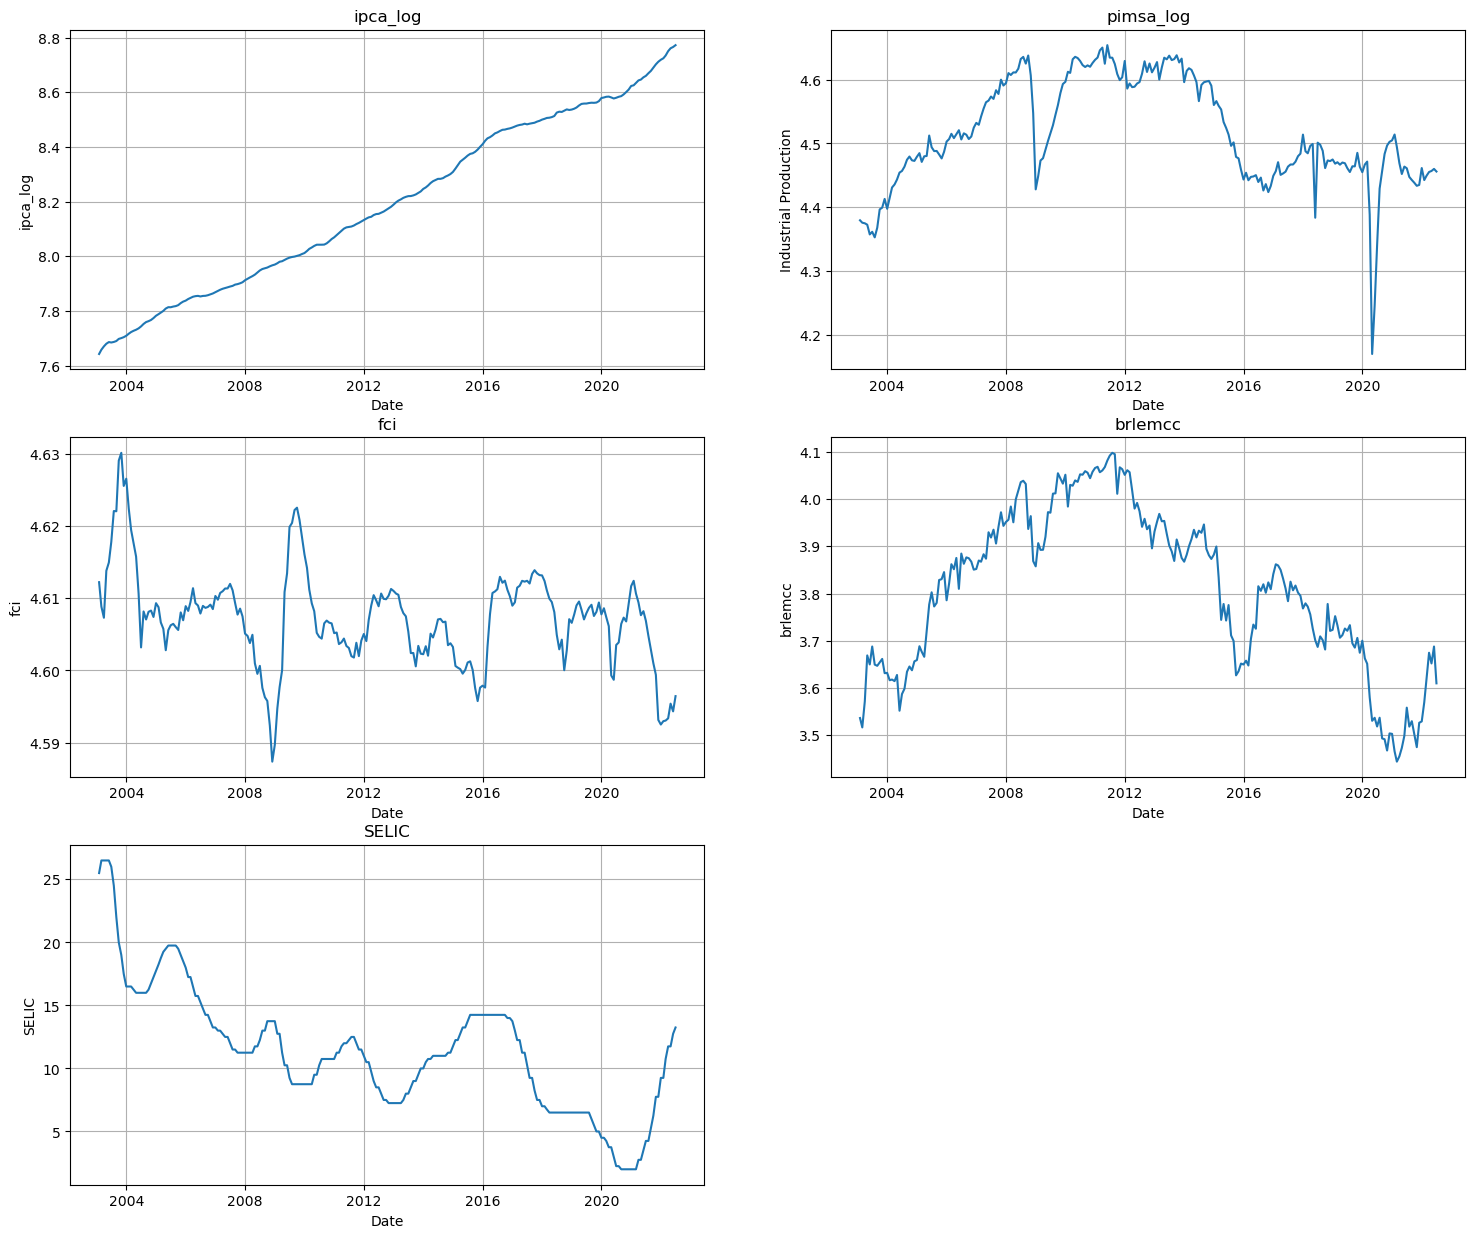

In [231]:
### taking a look at the data

plt.figure(figsize=(18,15))
plt.subplot(321)
plt.plot(df["ipca_log"])
plt.xlabel('Date')
plt.ylabel('ipca_log')
plt.title('ipca_log')
plt.grid()
plt.subplot(322)
plt.plot(df["pimsa_log"])
plt.xlabel('Date')
plt.ylabel('Industrial Production')
plt.title('pimsa_log')
plt.grid()
plt.subplot(324)
plt.plot(df["logbrlem"])
plt.xlabel('Date')
plt.ylabel('brlemcc')
plt.title('brlemcc')
plt.grid()
plt.subplot(323)
plt.plot(df["fci"])
plt.xlabel('Date')
plt.ylabel('fci')
plt.title('fci')
plt.grid()
plt.subplot(325)
plt.plot(df["Selic"])
plt.xlabel('Date')
plt.ylabel('SELIC')
plt.title('SELIC')
plt.grid()
plt.show()


### We have the data, now we need to define a class, so that it can estimate the parameters of the model with our data, identify the structural shocks and create impulse response functions.

In [248]:
class SVAR():
    def __init__(self, X, lags=2, num_impulses=100):  
        self.X = X
        self.num_vars = X.shape[1]
        self.num_obs = X.shape[0]
        self.lags = lags                 
        self.num_impulses = num_impulses 
        self.residuals_squared = None  # Adicionado para armazenar os erros quadrados

    def Xlags(self):
        XLAG = pd.DataFrame()
        for l in range(1, self.lags + 1):
            XLAG = pd.concat([XLAG, self.X.shift(l).add_suffix("-" + str(l))], axis=1)
        X_avlb_dta = self.X.iloc[self.lags:, :]
        XLAG_avlb_dta = XLAG.iloc[self.lags:, :]
        Xa = np.array(X_avlb_dta)
        XLAGa = np.array(XLAG_avlb_dta)
        return Xa, XLAGa

    def ols_fit(self):
        Xa, XLAGa = self.Xlags()
        Bhat = inv(XLAGa.T @ XLAGa) @ XLAGa.T @ Xa
        U = (Xa - XLAGa @ Bhat)
        Ωhat = U.T @ U

        # Salvar os erros quadrados no objeto SVAR
        self.residuals_squared = U

        return Bhat, U, Ωhat

    def identification(self):
        _, U, Ωhat = self.ols_fit()
        C = LA.cholesky(Ωhat)
        d = np.zeros(C.shape)
        np.fill_diagonal(d, np.diag(C))
        C = np.dot(np.linalg.inv(d), C)
        Ε = U @ inv(C).T
        return C, Ε

    def IRF(self):
        Xa, _ = self.Xlags()
        Bhat, _, _ = self.ols_fit()
        C, _ = self.identification()
        c_Bhat = np.vstack((Bhat.T, np.hstack((np.identity((self.lags-1) * self.num_vars),
                                               np.zeros([(self.lags-1) * self.num_vars, self.num_vars])))))

        IRF = np.zeros([self.num_impulses, self.num_vars, self.num_vars])
        Temp = np.identity(c_Bhat.shape[0])

        for t in range(self.num_impulses):
            ψ_t = Temp[:self.num_vars, :self.num_vars]
            IRF[t, :, :] = ψ_t @ C
            Temp = c_Bhat @ Temp

        irf = pd.DataFrame({i: IRF[i].flatten() for i in range(self.num_impulses)}).T
        irf.columns = ["Ε_IP>IP", "Ε_IPCA>IP", "Ε_IFIN>IP", "Ε_BRL>IP", "Ε_SELIC>IP",
                       "Ε_IPC>IPCA", "Ε_IPCA>IPCA", "Ε_IFIN>IPCA", "Ε_BRL>IPCA", "Ε_SELIC>IPCA",
                       "Ε_IP>IFIN", "Ε_IPCA>IFIN", "Ε_IFIN>IFIN", "Ε_BRL>IFIN", "Ε_SELIC>IFIN",
                       "Ε_IP>BRL", "Ε_IPCA>BRL", "Ε_IFIN>BRL", "Ε_BRL>BRL", "Ε_SELIC>BRL",
                       "Ε_IP>SELIC", "Ε_IPCA>SELIC", "Ε_IFIN>SELIC", "Ε_BRL>SELIC", "Ε_SELIC>SELIC"]
        return c_Bhat, irf

    def plot_irf(self, irf, columns_of_interest, ci_multiplier=1.96):
        fig, axs = plt.subplots(self.num_vars, 1, figsize=(4, 12))

        for i in range(self.num_vars):
            ax = axs[i]

            ax.plot(irf.index, irf[columns_of_interest[i]]*100, label='IRF', color='Navy', linewidth=2)
            ax.axhline(0, color='black', linestyle='--', linewidth=1)

            ax.set_title(f'{self.X.columns[i]}')
            ax.set_xlabel('Month')


            ax.legend()

        axs[0].set_title('SELIC')
        axs[1].set_title('IPCA')
        axs[2].set_title('Industrial Production')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig('SVAR_IRF.png', dpi=300, bbox_inches='tight')

        plt.show()


### Then, we can use our data to define an instance of the class, call the methods on this instance and check the results

In [249]:
#X = df[["pimsa_log", "ipca_log", "fci", "logbrlem","Selic","D_greve", "D_covid","D_GFC"]]
X = df[["pimsa_log", "ipca_log", "fci", "logbrlem","Selic"]]
Model1 = SVAR(X)
Xa, _ = Model1.Xlags()
Bhat, U, Ωhat = Model1.ols_fit()
C, Ε = Model1.identification()
C

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.23085991,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.12620925,  0.00394021,  1.        ,  0.        ,  0.        ],
       [ 0.18065561, -0.04479011,  0.14345695,  1.        ,  0.        ],
       [ 0.03505935,  0.06454535, -0.20365296,  0.10994609,  1.        ]])

In [250]:
_, irf = Model1.IRF()
irf[["Ε_SELIC>IPCA","Ε_SELIC>IP","Ε_SELIC>BRL","Ε_SELIC>IFIN","Ε_SELIC>SELIC"]]
irf

Ε_IP>IP  Ε_IPCA>IP  Ε_IFIN>IP  Ε_BRL>IP  Ε_SELIC>IP  Ε_IPC>IPCA  \
0   1.000000   0.000000   0.000000  0.000000    0.000000    0.230860   
1   1.190309   1.131945   0.402526  0.176255    0.002547    0.345049   
2   1.203626   1.819891   0.880546  0.202853    0.001416    0.411954   
3   1.100996   1.916822   1.115976  0.226879   -0.001637    0.454441   
4   0.971400   1.742234   1.349328  0.232317   -0.004188    0.484690   
..       ...        ...        ...       ...         ...         ...   
95  0.272291   0.257172   1.249845  0.045635    0.003602    0.360644   
96  0.271473   0.255488   1.247338  0.044776    0.003595    0.360565   
97  0.270667   0.253855   1.244853  0.043935    0.003588    0.360495   
98  0.269871   0.252270   1.242389  0.043114    0.003581    0.360434   
99  0.269085   0.250732   1.239945  0.042311    0.003573    0.360382   

    Ε_IPCA>IPCA  Ε_IFIN>IPCA  Ε_BRL>IPCA  Ε_SELIC>IPCA  ...  Ε_IP>BRL  \
0      1.000000     0.000000    0.000000      0.000000  ...  0.180656   
1      1.480580    -0.015051   -0.000923     -0.000015  ...  0.736977   
2      1.716084    -0.032533   -0.007996      0.000050  ...  0.821457   
3      1.837960    -0.059650   -0.014613      0.000130  ...  0.932483   
4      1.909104    -0.083547   -0.021447      0.000211  ...  0.957478   
..          ...          ...         ...           ...  ...       ...   
95     1.489251    -0.024078   -0.130187     -0.004994  ...  0.292328   
96     1.489852    -0.025232   -0.130524     -0.005002  ...  0.290341   
97     1.490483    -0.026390   -0.130857     -0.005010  ...  0.288405   
98     1.491143    -0.027551   -0.131185     -0.005019  ...  0.286518   
99     1.491831    -0.028716   -0.131508     -0.005027  ...  0.284679   

    Ε_IPCA>BRL  Ε_IFIN>BRL  Ε_BRL>BRL  Ε_SELIC>BRL  Ε_IP>SELIC  Ε_IPCA>SELIC  \
0    -0.044790    0.143457   1.000000     0.000000    0.035059      0.064545   
1     1.532006    2.104465   0.773342     0.008177    4.479992     21.879800   
2     2.129529    1.709726   0.877106     0.006087   11.618676     41.946303   
3     2.492458    1.928500   0.812032     0.007102   17.497712     55.671640   
4     2.594624    1.822784   0.806837     0.006936   22.588121     65.816126   
..         ...         ...        ...          ...         ...           ...   
95    0.087872    1.598674   0.112705     0.005672    0.280666     -4.357211   
96    0.082254    1.596010   0.111029     0.005664    0.287230     -4.316219   
97    0.076820    1.593345   0.109396     0.005657    0.294287     -4.274478   
98    0.071566    1.590680   0.107803     0.005649    0.301788     -4.232127   
99    0.066486    1.588014   0.106249     0.005642    0.309678     -4.189312   

    Ε_IFIN>SELIC  Ε_BRL>SELIC  Ε_SELIC>SELIC  
0      -0.203653     0.109946       1.000000  
1     -26.483437     1.378648       1.246100  
2     -35.525416    -0.144188       1.348025  
3     -43.941773    -0.846799       1.367895  
4     -48.101907    -1.793643       1.364446  
..           ...          ...            ...  
95      8.363892     0.048722       0.037220  
96      8.356397     0.060298       0.037096  
97      8.347754     0.071502       0.036989  
98      8.338073     0.082341       0.036898  
99      8.327462     0.092822       0.036821  

[100 rows x 25 columns]

### Now that we have our impulse response functions, we can plot them

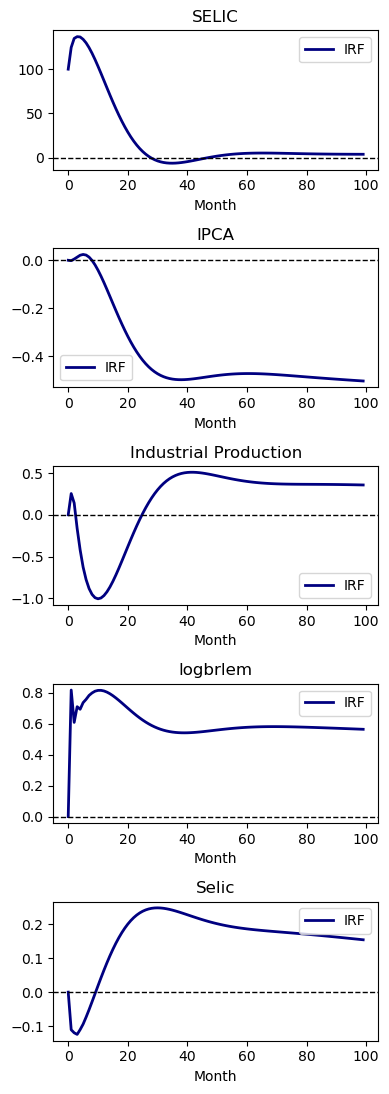

In [251]:
columns_of_interest = [  "Ε_SELIC>SELIC", "Ε_SELIC>IPCA", "Ε_SELIC>IP", "Ε_SELIC>BRL", "Ε_SELIC>IFIN"]
Model1.plot_irf(irf, columns_of_interest)

In [172]:
subset_data = irf

# Especifique o nome do arquivo Excel de saída
output_file = "data_subset.xlsx"

# Salve o DataFrame no arquivo Excel
subset_data.to_excel(output_file, index=False)